In [ ]:
%reload_ext autoreload
%autoreload 2
#matplotlib inline

In [ ]:
! pip install -q transformers[sentencepiece] fastbook fastai ohmeow-blurr nbdev

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *

/usr/local/lib/python3.10/dist-packages/blurr/text/modeling/question_answering.py:31: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  squad_metric = load_metric("squad")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Work/News/T2

/content/drive/MyDrive/Work/News/T2


### model building

In [ ]:
df = pd.read_csv("multi_label_dataset.csv")
df.head()

,Title,Body,label
0,Wildfires kill 34 in Algeria,"The death toll as wildfires sweep across regions of Algeria has risen to 34 people including 10 soldiers on Monday, the interior ministry said, as a heatwave spreads across north Africa and southern Europe.Some 8,000 firefighters were battling to bring the flames under control, authorities said.The interior ministry said that it is continuing its firefighting operations in the Boumerdes, Bouira, Tizi Ouzou, Jijel, Bejaia and Skikda regions.About 1,500 people have been evacuated so far.As temperatures hit 48°C in parts of the North African country, it recorded 97 blazes across 16 provinces,...","africa , WorldWide"
1,Algeria bus crash kills 34,"At least 34 people were killed and 12 others injured Wednesday in an accident in Algeria's south involving a passenger bus, the country's civil defence agency said.The head-on collision between the bus and a commercial vehicle caused a fire, the agency said as rescue operations were ongoing.The accident, one of the North African country's deadliest in years, occurred near the city of Tamanrasset, about a 2,000-kilometre drive south from the capital Algiers.Local media reported charred bodies were recovered from the bus.The civil defence agency said the bus was carrying passengers between T...","africa , WorldWide"
2,Bangladeshi shot dead in South Africa for not paying extortion,"A Bangladeshi man has been shot dead by a group of miscreants in South Africa for not paying extortion money. The deceased has been identified as Shamim Shikder, 40. He was a resident of Madaripur.The incident took place in Johannesburg city at around 8pm local time and 12pm Bangladesh time on Monday.He is survived by his wife, two sons, and two daughters.According to the victim's family members, Shamim went to South Africa some 14 years ago. He has a grocery shop with his brother-in-law in Johannesburg. On Monday, a group of miscreants demanded money from Shamim and his brother-in-law whe...","africa , WorldWide"
3,At least 22 people killed in airstrike on Sudan's Omdurman,"At least 22 people were killed in an airstrike by Sudan's military in the city of Omdurman on Saturday, health officials said.Numerous people were also injured in the attack, the Khartoum state Health Ministry said.The airstrike was one of the deadliest since clashes between the military and a powerful paramilitary group, the Rapid Support Forces, began in Sudan in mid-May.Last month, an airstrike killed at least 17 people, including five children in Khartoum. The RSF blamed the military for striking residential areas in Omdurman.Hotspot of fightingWhile the RSF quickly dominated the capit...","africa , WorldWide"
4,16 dead in South African slum gas leak,"At least 16 people, including children, have died after a gas leak at a South African slum near Johannesburg, emergency services said Thursday, revising the death toll after some people were resuscitated.The Wednesday night disaster, thought to be linked to illegal mining activities, occurred at the Angelo informal settlement east of Johannesburg.""We have got 16 on scene now that are confirmed dead, and the intervention of paramedics managed to revive some others and they were taken to hospital,"" emergency services spokesman William Ntladi told AFP from the scene.Of those in hospital, four...","africa , WorldWide"


In [ ]:
df.shape

(31856, 3)

In [ ]:
df.dropna().reset_index(drop=True)
df.shape

(31856, 3)

In [ ]:
label_list = df['label'].to_list()
label_count = {}

for labels in label_list:
    label_list_split = labels.split(',')
    for label in label_list_split:
        label = label.strip()
        if label in label_count:
            label_count[label] += 1
        else:
            label_count[label] = 1

print(f"Number of labels: {len(label_count)}")
print(label_count)

Number of labels: 22
{'africa': 1860, 'WorldWide': 11460, 'asia': 1935, 'banks': 1939, 'Business': 7002, 'commerce': 1130, 'cricket': 1940, 'Sports': 7640, 'crime': 1933, 'National(BD)': 5754, 'economy': 1866, 'education': 1913, 'europe': 1939, 'football': 1908, 'middle-east': 1924, 'north-america': 1929, 'other-sports': 1859, 'politics': 1908, 'real-estate': 132, 'south-asia': 1873, 'stock-market': 1935, 'tennis': 1933}


In [ ]:
encode_label_type = { key: idx for idx, (key,value) in enumerate (label_count.items()) }
with open ("label_types_encode.json","w") as fp:
  json.dump(encode_label_type, fp)

In [ ]:

from collections import Counter

# Encoding label types
label_counter = Counter()
for labels in df['label']:
    label_counter.update([label.strip() for label in labels.split(',')])

encode_label_type = {label: idx for idx, (label, _) in enumerate(label_counter.items())}
with open("label_types_encoded.json", "w") as fp:
    json.dump(encode_label_type, fp)

# Convert labels to categorical format
categorical_label_list = []

label_list = df['label'].to_list()

for labels in label_list:
    categorical_list = [0] * len(encode_label_type)
    label_list_split = [label.strip() for label in labels.split(',')]
    for label in label_list_split:
        if label in encode_label_type:
            label_type_index = encode_label_type[label]
            categorical_list[label_type_index] = 1
    categorical_label_list.append(categorical_list)

df['categorical_label'] = categorical_label_list

print(encode_label_type)
print(categorical_label_list[2][:33])


{'africa': 0, 'WorldWide': 1, 'asia': 2, 'banks': 3, 'Business': 4, 'commerce': 5, 'cricket': 6, 'Sports': 7, 'crime': 8, 'National(BD)': 9, 'economy': 10, 'education': 11, 'europe': 12, 'football': 13, 'middle-east': 14, 'north-america': 15, 'other-sports': 16, 'politics': 17, 'real-estate': 18, 'south-asia': 19, 'stock-market': 20, 'tennis': 21}
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
encode_label_type

{'africa': 0,
 'WorldWide': 1,
 'asia': 2,
 'banks': 3,
 'Business': 4,
 'commerce': 5,
 'cricket': 6,
 'Sports': 7,
 'crime': 8,
 'National(BD)': 9,
 'economy': 10,
 'education': 11,
 'europe': 12,
 'football': 13,
 'middle-east': 14,
 'north-america': 15,
 'other-sports': 16,
 'politics': 17,
 'real-estate': 18,
 'south-asia': 19,
 'stock-market': 20,
 'tennis': 21}

In [ ]:
df['categorical_label'] = categorical_label_list
df.tail()

,Title,Body,label,categorical_label
31851,Venus wins first title for 16 months,"Venus Williams, the seven times former Grand Slam champion, won the WTA Dubai Oopen on Saturday to silence some of the doubters who said she could never make a significant come-back at the age of 33.Williams produced a magnificent performance by outplaying the tournament's sensation, Alise Cornet, 6-3, 6-0 to earn her a first title in 16 months.Williams only gained entry into the Dubai Open with a wild card after falling outside the top 40, yet completed five fine wins.In doing so she avenged the defeat which the French player had inflicted on her sister Serena Williams in the semi-finals,...","tennis , Sports","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
31852,Nadal survives to reach Rio final,"World number one Rafael Nadal survived two match points in a three-set victory over fellow Spaniard Pablo Andujar on Saturday to reach the final of the Rio Open tennis tournament.Nadal reached his third final in three ATP tournaments this year with a 2-6, 6-3, 7-6 (12/10) triumph, but the determined Andujar, seeded eighth, made him work until the bitter end.After a late exchange of breaks in the third set sent the match to a tiebreaker, it was Nadal who had the first chance to put the match away, at 6-5 in the decider.Andujar saved the match point with a forehand winner, then mustered two ...","tennis , Sports","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
31853,Cornet shocks Serena to reach Dubai final,"Alize Cornet, recovering brilliantly from a mighty collapse in career fortunes, scored her best-ever win by beating world number one Serena Williams 6-4, 6-4 and preventing an all-Williams sisters final at the Dubai Open.The 24-year-old Frenchwoman, who is about to return to the top 20 after a dismal five-year interval in which she fell from the top 100, made a mere handful of errors as she manoeuvred and harassed the legend to a stunning defeat.Cornet often rallied valiantly when the powerful American landed her biggest blows, but even more often she found changes of direction and angles ...","tennis , Sports","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
31854,Nadal to face Andujar in Rio semis,"Spain's world number one Rafael Nadal is through to the semi-finals of the $1.3 million ATP Rio Open after crushing Joao Sousa of Portugal 6-1, 6-0 in the last eight on Friday.""I think I played my best match of the week today,"" said top seed Nadal after a crushing win in 75 minutes kept his run going in what is his first event since losing last month's Australian Open final.As he looks to reach his third final in three tournaments this year, he will now face compatriot Pablo Andujar after the eighth seed won 6-1, 6-1 against another Spaniard, Tommy Robredo.In the other semi-final, Spain's ...","tennis , Sports","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
31855,Serena and Jankovic have another spat,"World number one Serena Williams' comeback trail endured further feisty moments with Jelena Jankovic, the former world number one from Serbia, On Thursday before she reached the semi-finals of the Dubai Open.The two have exchanged testy words on several occasions, the last time in October when Jankovic appeared to question Serena's sportsmanship at the WTA Championships in Istanbul.Now, near the end of Serena's impressive 6-2, 6-2 win, a dispute blew up over the speed at which the rallies were conducted, an issue which has been a contention between them several times.It happened when Janko...","tennis , Sports","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"


### Dataloaders and modeling

In [ ]:
labels = list(encode_label_type.keys())

In [ ]:
model_name = "distilroberta-base"
model_cls= AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type= "multi_label_classification"

In [ ]:
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), MultiCategoryBlock(encoded=True, vocab=labels))
dblock = DataBlock(blocks=blocks, get_x=ColReader('Body'), get_y=ColReader('categorical_label'), splitter=RandomSplitter(valid_pct=0.1, seed=42))

In [ ]:
dls = dblock.dataloaders(df,bs=32)
torch.save(dls,"dataloaders/dls_multilbl_news-classifier.pkl")

In [ ]:
dls.vocab

['africa', 'WorldWide', 'asia', 'banks', 'Business', 'commerce', 'cricket', 'Sports', 'crime', 'National(BD)', 'economy', 'education', 'europe', 'football', 'middle-east', 'north-america', 'other-sports', 'politics', 'real-estate', 'south-asia', 'stock-market', 'tennis']

In [ ]:
dls.show_batch(dataloaders=dls, max_n=4, trunc_at=512)

,text,target
0,Introduction and BackgroundThis is the first time in the history of Bangladesh that an elected Government has stepped into its second term in office having successfully completed the first one. This bears testimony to the unflinching trust that the people have chosen to bestow on us. We believe that this continuity will enable the Government to take forward its development initiatives to a higher trajectory. The Honourable Prime Minister Sheikh Hasina took steps to hold the national election under an all-p,"[Business, economy]"
1,"Surveying Beirut’s shattered streets last week, in the aftermath of a massive explosion at the port that killed at least 158 people, French President Emmanuel Macron offered support to the people of Lebanon and delivered a stern message to the country’s ruling class.What Lebanon needs, he said, is fundamental change.“Strong political initiatives must be undertaken to fight corruption, to impose transparency and to carry out reforms put forward two years ago” at a conference of international donors in Paris","[WorldWide, middle-east]"
2,"Among several exercises or practices which the athletes around the world do in order to improve their performance, controlling breath is one of the most important because of its significant benefit on health, mind and body.\r\n\r\nThere is barely any international sport in the Olympics that requires breath-holding so kabaddi's sense of uniqueness in that regard makes the game a surprise to the outside world.\r\n\r\nApart from the art of holding breath, another factor that makes kabaddi different from all the other","[Sports, other-sports]"
3,"ParticipationsCameroon (8) Morocco (6) Nigeria (6) Tunisia (5) Algeria (4) Ghana (4) Côte d'Ivoire (3) Egypt (3) Senegal (3) South Africa (3) Angola (1) Congo DR (1)Togo (1)Memorable momentsAfrica's maiden triumph Nobody gave Tunisia, who didn't even qualify for the 1976 AFCON, a shot at seizing Africa's solitary place at Argentina 1978. When The Eagles of Carthage stunned the likes of Morocco, Algeria, Nigeria and Egypt to claim that spot, however, they were determined to make the most of their opportunit","[Sports, football]"


In [ ]:
doc(accuracy_multi)

In [ ]:
model = BaseModelWrapper(hf_model)

acc_02 = partial(accuracy_multi, thresh= 0.2)

learner= Learner(dls,
                 model,
                 opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
                 loss_func=BCEWithLogitsLossFlat(),
                 metrics=[acc_02],
                 cbs=[BaseModelCallback],
                 splitter=blurr_splitter
                 ).to_fp16()

### stage 0

In [ ]:
learner.freeze()

SuggestedLRs(slide=0.0020892962347716093, valley=0.00015848931798245758)

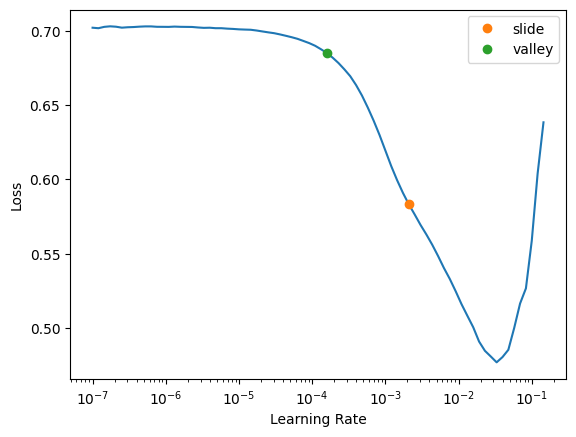

In [ ]:
learner.lr_find(suggest_funcs=(slide, valley))

In [ ]:
learner.fit_one_cycle(3, slice(1.6e-4, 2.2e-3))


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.034897,0.030150,0.988012,06:28
1,0.026448,0.024708,0.988711,06:32
2,0.020750,0.022612,0.990153,06:37


In [ ]:
learner.save("news-classifier-stage-0")

Path('models/news-classifier-stage-0.pth')

In [ ]:
learner.export("models/news_classifier-stage-0.pkl")

### Stage 1

In [ ]:
learner.load("news-classifier-stage-0")

In [ ]:
learner.freeze()

SuggestedLRs(slide=0.0020892962347716093, valley=0.0012022644514217973)

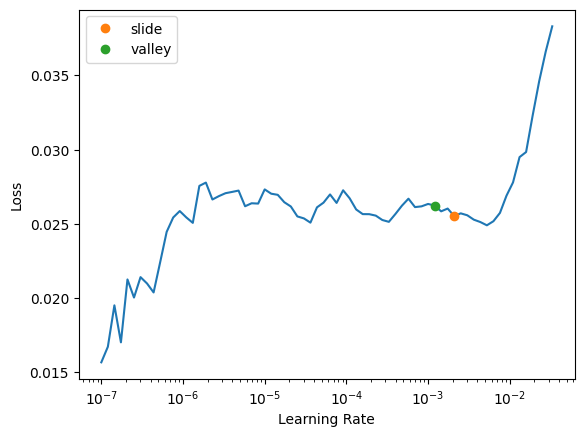

In [ ]:
learner.lr_find(suggest_funcs=(slide, valley))

In [ ]:
learner.fit_one_cycle(5, slice( 1.5e-3,3.75e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.022912,0.025561,0.989525,06:33
1,0.025282,0.024702,0.989097,06:32
2,0.024007,0.023571,0.990053,06:32
3,0.022361,0.023217,0.990410,06:33
4,0.020431,0.023379,0.990281,06:33


In [ ]:
learner.save("news-classifier-stage-1")

Path('models/news-classifier-stage-1.pth')

In [ ]:
learner.export("models/news_classifier-stage-1.2.pkl")

In [ ]:
learner.load("news-classifier-stage-1")

In [ ]:
learner.freeze()

SuggestedLRs(slide=0.0010000000474974513, valley=0.0005754399462603033)

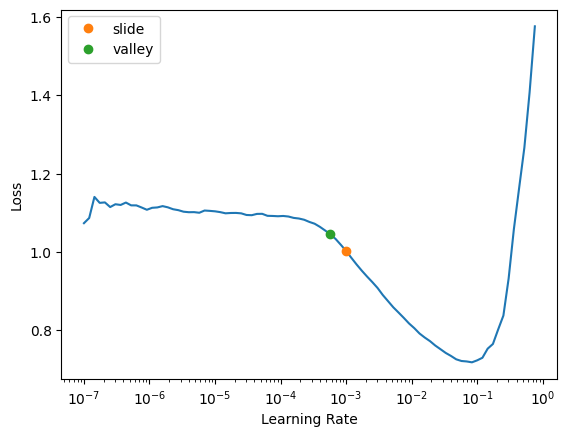

In [ ]:
learner.lr_find(suggest_funcs=(slide, valley))

In [ ]:
learner.fit_one_cycle(2, slice( 5.9e-4, 1.2e-3))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.027264,0.025442,0.989725,07:06
1,0.020841,0.023376,0.990424,06:55


In [ ]:
learner.save("news-classifier-stage-2")

Path('models/news-classifier-stage-2.pth')

In [ ]:
learner.export("models/news_classifier-stage-2.pkl")

### ONNX

In [ ]:
! pip install -q onnxruntime onnx==1.10.0 onnxruntime-gpu onnxruntime_tools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 11.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *

In [ ]:
from tqdm.notebook import tqdm
import numpy as np

In [ ]:
df = pd.read_csv("multi_label_dataset.csv")

In [ ]:

from collections import Counter

# Encoding label types
label_counter = Counter()
for labels in df['label']:
    label_counter.update([label.strip() for label in labels.split(',')])

encode_label_type = {label: idx for idx, (label, _) in enumerate(label_counter.items())}
with open("label_types_encoded.json", "w") as fp:
    json.dump(encode_label_type, fp)

# Convert labels to categorical format
categorical_label_list = []

label_list = df['label'].to_list()

for labels in label_list:
    categorical_list = [0] * len(encode_label_type)
    label_list_split = [label.strip() for label in labels.split(',')]
    for label in label_list_split:
        if label in encode_label_type:
            label_type_index = encode_label_type[label]
            categorical_list[label_type_index] = 1
    categorical_label_list.append(categorical_list)

df['categorical_label'] = categorical_label_list

print(encode_label_type)
print(categorical_label_list[2][:33])


{'africa': 0, 'WorldWide': 1, 'asia': 2, 'banks': 3, 'Business': 4, 'commerce': 5, 'cricket': 6, 'Sports': 7, 'crime': 8, 'National(BD)': 9, 'economy': 10, 'education': 11, 'europe': 12, 'football': 13, 'middle-east': 14, 'north-america': 15, 'other-sports': 16, 'politics': 17, 'real-estate': 18, 'south-asia': 19, 'stock-market': 20, 'tennis': 21}
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
labels = list(encode_label_type.keys())
len(labels), labels[:5]

(22, ['africa', 'WorldWide', 'asia', 'banks', 'Business'])

In [ ]:
len(labels), labels[:5]

(22, ['africa', 'WorldWide', 'asia', 'banks', 'Business'])

In [ ]:
encode_label_type

{'africa': 0,
 'WorldWide': 1,
 'asia': 2,
 'banks': 3,
 'Business': 4,
 'commerce': 5,
 'cricket': 6,
 'Sports': 7,
 'crime': 8,
 'National(BD)': 9,
 'economy': 10,
 'education': 11,
 'europe': 12,
 'football': 13,
 'middle-east': 14,
 'north-america': 15,
 'other-sports': 16,
 'politics': 17,
 'real-estate': 18,
 'south-asia': 19,
 'stock-market': 20,
 'tennis': 21}

## Data splitter

In [ ]:
splitter = RandomSplitter(valid_pct=0.1, seed=42)
train_ids, valid_ids = splitter(df)
len(train_ids), len(valid_ids)

(28671, 3185)

In [ ]:
valid_df = df.loc[valid_ids]
valid_df.head()

,Title,Body,label,categorical_label
5110,Pubali Bank opens ATM Booth at Netrakona’s Madan,"Pubali Bank has opened an ATM Booth at its Madan branch in Netrakona.\r\n\r\nMd Abdul Halim Chowdhury, managing director and CEO of the bank, inaugurated the booth as the chief guest on Monday.\r\n\r\nThe bank’s Additional Managing Director Safiul Alam Khan Chowdhury and Deputy Managing Director Mohammad Ali were also present as the guest of honour and special guest, respectively.\r\n\r\nDGM and RM of the Mymensingh region Md Rafiqul Islam was also present.","banks , Business","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
26488,UN: Myanmar opium cultivation surging under military rule,"Opium cultivation in military-ruled Myanmar jumped 33% last year, reversing a six-year downward trend in the strife-torn country, a United Nations report said on Thursday.The growth was ""directly connected"" to the political and economic turmoil in Myanmar since the military took power in a coup nearly two years ago, an official at the United Nations Office on Drugs and Crime (UNODC) said.""Economic, security and governance disruptions that followed the military takeover of February 2021 have converged, and farmers in remote, often conflict-prone areas... have had little option but to move b...","south-asia , WorldWide","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
18180,Spirit of 2018 alive as France show collective force,"Didier Deschamps made only one late substitution as France beat England 2-1 in a nerve-racking World Cup quarter-final on Saturday, but the defending champions have been carried over the line by an unshakable collective strength in the squad.Les Bleus' main weakness was their lack of solutions from the bench and Deschamps only sent Kingsley Coman in for Ousmane Dembele in the 79th minute just after Olivier Giroud headed home what turned out to be the winner at the Al Bayt stadium.It was just enough as England captain Harry Kane missed an 84th minute penalty that would have made it 2-2 and ...","football , Sports","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
26168,Will IMF deal end Pakistan's economic misery?,"Irfan Ali, a 22-year-old resident of Rawalpindi city, has been struggling to make ends meet over the past year. Pakistan's grave economic crisis has resulted in massive layoffs during this period and Ali, who was working for a real-estate firm, also lost his job.He's managed to find work at a ride-hailing app, but says income-earning opportunities from it are limited, as demand for such services is down amid the gloomy economic climate and extremely hot summer weather.Ali says he's currently earning about $78 a month, which isn't enough to support his eight-member household, including his...","south-asia , WorldWide","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
2074,UN: Myanmar landmine casualties surge two years after coup,"Landmines and unexploded munitions injured or killed more than one person every day in Myanmar last year, the United Nations said, pointing to a 40% spike in casualties compared to 2021.The military's toppling of Aung San Suu Kyi's government in 2021 sparked renewed fighting with ethnic rebel groups and the formation of dozens of ""People's Defence Forces"" in areas previously untouched by decades of conflict in Myanmar.The Southeast Asian nation is not a signatory to the United Nations convention that prohibits the use, stockpiling or development of anti-personnel mines.The United Nations C...","asia , WorldWide","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


### Fastai & Blur interface

In [ ]:
model_path = "models/news_classifier-stage-0.pkl"
learner_inf = load_learner(model_path)

In [ ]:
encode_label_type

{'africa': 0,
 'WorldWide': 1,
 'asia': 2,
 'banks': 3,
 'Business': 4,
 'commerce': 5,
 'cricket': 6,
 'Sports': 7,
 'crime': 8,
 'National(BD)': 9,
 'economy': 10,
 'education': 11,
 'europe': 12,
 'football': 13,
 'middle-east': 14,
 'north-america': 15,
 'other-sports': 16,
 'politics': 17,
 'real-estate': 18,
 'south-asia': 19,
 'stock-market': 20,
 'tennis': 21}

In [ ]:
learner_inf.model.hf_model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [ ]:
learner_inf.blurr_predict("random placeholder")

[{'labels': [],
  'scores': [],
  'class_indices': [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  'class_labels': ['africa', 'WorldWide', 'asia', 'banks', 'Business', 'commerce', 'cricket', 'Sports', 'crime', 'National(BD)', 'economy', 'education', 'europe', 'football', 'middle-east', 'north-america', 'other-sports', 'politics', 'real-estate', 'south-asia', 'stock-market', 'tennis'],
  'probs': [0.005288929212838411,
   0.2281213104724884,
   0.006909106858074665,
   0.0045226747170090675,
   0.05196657404303551,
   0.01827067881822586,
   0.0008126689936034381,
   0.07317215949296951,
   0.004623460117727518,
   0.015479749999940395,
   0.018709685653448105,
   0.048506785184144974,
   0.01567123830318451,
   0.00028208221192471683,
   0.0021613251883536577,
   0.051837027072906494,
   0.3216709792613983,
   2.8798782295780256e-05,
   0.0009498734143562615,
   8.512590284226462e-05,
   8.266323857242

In [ ]:
learner_inf.blurr_predict(["random placeholder","football"])[1]['labels'],learner_inf.blurr_predict(["random placeholder","pubali"])[1]['labels'],learner_inf.blurr_predict(["random placeholder","business"])[1]['labels'],

(['Sports', 'other-sports'], ['other-sports'], ['Business', 'other-sports'])

## Evaluation

In [ ]:
from sklearn import metrics

def metric_measures(test_df, preds):

  targets = [np.asarray(target) for target in test_df['categorical_label'].to_list()]
  outputs = [np.asarray(pred) for pred in preds]


  accuracy = metrics.accuracy_score(targets, outputs)
  f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
  f1_score_macro = metrics.f1_score(targets, outputs, average='macro')

  print(f"F1 Score (Micro) = {f1_score_micro}")
  print(f"F1 Score (Macro) = {f1_score_macro}")

  return

In [ ]:
preds = []
for idx, row in tqdm(valid_df.iterrows(), total=len(valid_df)):
  desc = row['Body']
  labels = learner_inf.blurr_predict(desc)[0]['labels']
  pred_genres = [0] * len(encode_label_type)
  for label in labels:
    pred_genres[encode_label_type[label]] = 1
  preds.append(pred_genres)

preds[0][:20]

  0%|          | 0/3185 [00:00<?, ?it/s]

[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
metric_measures(valid_df, preds)

F1 Score (Micro) = 0.9561928774030886
F1 Score (Macro) = 0.933595182430791


# Convert to ONNX

In [ ]:
model_path = "models/news_classifier-stage-0.pkl"
learner_inf = load_learner(model_path)

In [ ]:
classifier = learner_inf.model.hf_model.eval()

torch.onnx.export(
    classifier,
    torch.LongTensor([[0] * 512]),
    'models/news-classifier.onnx',
    verbose=True,
    input_names=['input_ids'],
    output_names=['output'],
    opset_version=13,
    dynamic_axes={
        'input_ids': {0: 'batch_size', 1: 'sequence_len'},
        'output': {0: 'batch_size'}
    }
)

In [ ]:
!pip install onnx onnxruntime onnxruntime-tools



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 35.4 MB/s eta 0:00:00
  Using cached onnxruntime-1.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.7 MB/s eta 0:00:00


In [ ]:
from onnxruntime.quantization import quantize_dynamic, QuantType

onnx_model_path = 'models/news-classifier.onnx'
quantized_onnx_model_path = 'models/news-classifier-quantized.onnx'

quantize_dynamic(
    onnx_model_path,
    quantized_onnx_model_path,
    weight_type=QuantType.QUInt8,
)

Ignore MatMul due to non constant B: /[/roberta/encoder/layer.0/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.0/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.1/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.1/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.2/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.2/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.3/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.3/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.4/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.4/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/roberta/encoder/layer.5/attention/self/MatMul]
Ignore MatMul due to non constant

In [ ]:
encode_label_type

{'africa': 0,
 'WorldWide': 1,
 'asia': 2,
 'banks': 3,
 'Business': 4,
 'commerce': 5,
 'cricket': 6,
 'Sports': 7,
 'crime': 8,
 'National(BD)': 9,
 'economy': 10,
 'education': 11,
 'europe': 12,
 'football': 13,
 'middle-east': 14,
 'north-america': 15,
 'other-sports': 16,
 'politics': 17,
 'real-estate': 18,
 'south-asia': 19,
 'stock-market': 20,
 'tennis': 21}

# ONNX Inference

## Normal ONNX

In [ ]:
!pip install onnxruntime-gpu


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.7 MB/s eta 0:00:00


In [ ]:
import onnxruntime as rt
from transformers import AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

class_labels = list(encode_label_type.keys())

inf_session = rt.InferenceSession('models/news-classifier.onnx',providers=['CUDAExecutionProvider'])
input_name = inf_session.get_inputs()[0].name
output_name = inf_session.get_outputs()[0].name

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


In [ ]:
preds = []
for idx, row in tqdm(valid_df.iterrows(), total=valid_df.shape[0]):
  desc = row['Body']
  input_ids = tokenizer(desc)['input_ids'][:512]

  probs = inf_session.run([output_name], {input_name: [input_ids]})[0]
  probs = torch.FloatTensor(probs)

  masks = torch.sigmoid(probs) >= 0.2
  labels = [class_labels[idx] for idx, mask in enumerate(masks[0]) if mask]

  pred_genres = [0] * len(encode_label_type)
  for label in labels:
    pred_genres[encode_label_type[label]] = 1
  preds.append(pred_genres)

  0%|          | 0/3185 [00:00<?, ?it/s]

In [ ]:
metric_measures(valid_df, preds)

F1 Score (Micro) = 0.9473442522577683
F1 Score (Macro) = 0.9281774146430187


In [ ]:
encode_label_type

{'africa': 0,
 'WorldWide': 1,
 'asia': 2,
 'banks': 3,
 'Business': 4,
 'commerce': 5,
 'cricket': 6,
 'Sports': 7,
 'crime': 8,
 'National(BD)': 9,
 'economy': 10,
 'education': 11,
 'europe': 12,
 'football': 13,
 'middle-east': 14,
 'north-america': 15,
 'other-sports': 16,
 'politics': 17,
 'real-estate': 18,
 'south-asia': 19,
 'stock-market': 20,
 'tennis': 21}

### Diffrent approach

In [ ]:
from transformers import AutoTokenizer
import torch
import onnxruntime as rt

tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
class_labels = list(encode_label_type.keys())
# Load the ONNX model
onnx_model_path = 'models/news-classifier.onnx'
inf_session = rt.InferenceSession(onnx_model_path)
input_name = inf_session.get_inputs()[0].name
output_name = inf_session.get_outputs()[0].name

In [ ]:
preds_onnx = []
for idx, row in tqdm(valid_df.iterrows(), total=valid_df.shape[0]):
    desc = row['Body']
    input_ids = tokenizer(desc, return_tensors="pt", truncation=True, max_length=512)['input_ids'].numpy()

    probs = inf_session.run([output_name], {input_name: input_ids})[0]
    probs = torch.FloatTensor(probs)

    masks = torch.sigmoid(probs) >= 0.5  # Ensure the threshold here is the same as for the PyTorch model
    labels = [class_labels[idx] for idx, mask in enumerate(masks[0]) if mask]

    pred_genres = [0] * len(encode_label_type)
    for label in labels:
        pred_genres[encode_label_type[label]] = 1
    preds_onnx.append(pred_genres)

  0%|          | 0/3185 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
metric_measures(valid_df, preds)

F1 Score (Micro) = 0.9473442522577683
F1 Score (Macro) = 0.9281774146430187


## Quantized ONNX

In [ ]:
import onnxruntime as rt
from transformers import AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

class_labels = list(encode_label_type.keys())

inf_session = rt.InferenceSession('models/news-classifier-quantized.onnx',providers=['CUDAExecutionProvider'])
input_name = inf_session.get_inputs()[0].name
output_name = inf_session.get_outputs()[0].name

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


In [ ]:
preds = []
for idx, row in tqdm(valid_df.iterrows(), total=valid_df.shape[0]):
  desc = row['Body']
  input_ids = tokenizer(desc)['input_ids'][:512]

  probs = inf_session.run([output_name], {input_name: [input_ids]})[0]
  probs = torch.FloatTensor(probs)

  masks = torch.sigmoid(probs) >= 0.2
  labels = [class_labels[idx] for idx, mask in enumerate(masks[0]) if mask]

  pred_genres = [0] * len(encode_label_type)
  for label in labels:
    pred_genres[encode_label_type[label]] = 1
  preds.append(pred_genres)

  0%|          | 0/3185 [00:00<?, ?it/s]

In [ ]:
metric_measures(valid_df, preds) #

F1 Score (Micro) = 0.9485311037815448
F1 Score (Macro) = 0.9306659700528906
